# Install

In [1]:
pip install earthpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 20.8 MB/s eta 0:00:00


In [2]:
pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 1.3 MB/s eta 0:00:00


In [3]:
pip install pyhdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 771.6/771.6 kB 4.4 MB/s eta 0:00:00


In [4]:
pip install polars

## packages

In [5]:
import os
import warnings
import datetime
import pytz
import re
import pickle
import functools
from collections import OrderedDict

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import numpy as np
import pandas as pd
import numpy.ma as ma
import polars as pl
from shapely.geometry import mapping, box
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import dask.array as da

from pyhdf.SD import SD, SDC

import pyproj
import re

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import polars as pl
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

from tqdm import tqdm
## https://hdfeos.org/software/pyhdf.php
warnings.simplefilter('ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import sys
sys.path.append('/content/drive/MyDrive/lpg_analysis')
from model import (
    get_dates_pl,
    process_data,
    get_fourier_components,
    plot_contour,
    get_joint_distribution,
    get_piecewise_contribution,
    y_distribution,
    get_piecewise_posterior,
    run_chain,
    get_post,
)

Instructions for updating:
experimental_compile is deprecated, use jit_compile instead


## data

In [7]:
"""
shape = (n_blocks_per_row, n_blocks_per_row, n_timeperiods, n_vars, n_changepoints) # after axis swap
shape = (120, 120, 560, 6)
axis 3 metric order ['qa', 'std', 'mean', 'percentile_10', 'median', 'percentile_90']
# ndvi valid range -2000 to 10000, fill value = -3000
"""
cities = pd.read_csv("/content/drive/MyDrive/propane/cities.csv").values

propane = (
    pl.from_pandas(pd.read_csv('/content/drive/MyDrive/propane/demand_residential_monthly.csv'))
    .with_columns(
        period_start = pl.col('period_start').str.to_date(format='%m/%d/%Y'),
        period_ahead_2 = pl.col('period_ahead_2').str.to_date(format='%m/%d/%Y'),
        period_ahead_4 = pl.col('period_ahead_4').str.to_date(format='%m/%d/%Y'),
    )
)

path = '/content/drive/MyDrive/propane/data_agg/dates_pm25.pickle'
with open(path, 'rb') as f:
    dates = pickle.load(f)
print(f"dates.min(): {dates.min()}, dates.max(): {dates.max()}")

# filter satellite dates to match where we have demand data with the lags
mask_dates = (
    (pd.to_datetime(dates) >= pd.to_datetime(propane['period_ahead_4'].min()))
    &
    (pd.to_datetime(dates) <= pd.to_datetime(propane['period_ahead_4'].max()))
)
dates = dates[mask_dates]

#---------------------------------------------------------------
# shape = (n_blocks_per_row, n_blocks_per_row, n_timeperiods, n_vars, n_changepoints)
path = '/content/drive/MyDrive/propane/data_agg/pm25.pickle'
with open(path, 'rb') as f:
    pm25 = pickle.load(f)
    pm25 = pm25[:, :, mask_dates, :, :]

path = '/content/drive/MyDrive/propane/data_agg/lat_pm25.pickle'
with open(path, 'rb') as f:
    lat = pickle.load(f)

path = '/content/drive/MyDrive/propane/data_agg/lon_pm25.pickle'
with open(path, 'rb') as f:
    lon = pickle.load(f)


#---------------------------------------------------------------
print(f"pm25.shape: {pm25.shape}")
print(f"dates.shape: {len(dates):}")

dates.min(): 2015-01-01 00:00:00, dates.max(): 2022-12-01 00:00:00
pm25.shape: (100, 100, 92, 1, 1)
dates.shape: 92


In [8]:
dates_pl = (
    pl.from_pandas(pd.DataFrame({
        'date': pd.to_datetime(dates),
        'year': pd.to_datetime(dates).year,
        'month': pd.to_datetime(dates).month,
    }))
    .with_columns(
        month = pl.col('month').cast(str).str.zfill(2),
        day = pl.lit('01'),
    )
    .with_columns(
        year_month = pl.concat_str(
            [pl.col('year'), pl.col('month'), pl.col('day')],
            separator='-').str.to_date("%Y-%m-%d"),

    )
    .sort(['date'])
)

year_months = np.sort(dates_pl['year_month'].unique().to_numpy())
display(
    dates_pl
)

date,year,month,day,year_month
datetime[ns],i32,str,str,date
2015-05-01 00:00:00,2015,"""05""","""01""",2015-05-01
2015-06-01 00:00:00,2015,"""06""","""01""",2015-06-01
2015-07-01 00:00:00,2015,"""07""","""01""",2015-07-01
2015-08-01 00:00:00,2015,"""08""","""01""",2015-08-01
2015-09-01 00:00:00,2015,"""09""","""01""",2015-09-01
2015-10-01 00:00:00,2015,"""10""","""01""",2015-10-01
2015-11-01 00:00:00,2015,"""11""","""01""",2015-11-01
2015-12-01 00:00:00,2015,"""12""","""01""",2015-12-01
2016-01-01 00:00:00,2016,"""01""","""01""",2016-01-01


In [9]:

print(f"ndvi.shape: {pm25.shape}")
print(f"dates.shape: {len(dates):}")
print(f"dates.min(): {dates.min()}, dates.max(): {dates.max()}")

col='period_ahead_4'
assert dates.shape[0] == (
    propane
    .join(
        other=dates_pl.select(['year_month']),
        left_on=[col],
        right_on=['year_month'],
        how='inner',
    )
).shape[0]

ndvi.shape: (100, 100, 92, 1, 1)
dates.shape: 92
dates.min(): 2015-05-01 00:00:00, dates.max(): 2022-12-01 00:00:00


# Data Prep

## y: ndvi

In [10]:
"""
Y: ndvi
X: fourier components, piecewise_vars = trend, clouds, rain, heat, propane
shape = (n_blocks_per_row, n_blocks_per_row, n_timeperiods, n_vars, n_changepoints)
"""
y_data = pm25[:, :, :, :, :]

mu = y_data.mean(axis=2, keepdims=True)
sigma = y_data.std(axis=2, keepdims=True)
y_std = (y_data - mu) / sigma

start_lat=70
stop_lat=80
start_lon=22
stop_lon=32

plus_minus = 15
start_lat = start_lat - plus_minus
stop_lat = stop_lat + plus_minus
start_lon = start_lon - plus_minus
stop_lon = stop_lon + plus_minus

# start_lat=0
# stop_lat=100
# start_lon=0
# stop_lon=100

y_std = y_std[start_lon:stop_lon, start_lat:stop_lat, :, :, :]

n_blocks_per_row = y_std.shape[0]

print(f"y_std.shape: {y_std.shape}")

y_std.shape: (40, 40, 92, 1, 1)


## X_fourier

In [11]:
X_fourier = get_fourier_components(
    n_timeperiods=len(dates),
    n_blocks_per_row=n_blocks_per_row,
    periodicity=12,
    n_components=2,
)
print(f"X_fourier.shape: {X_fourier.shape}")

X_fourier.shape: (40, 40, 92, 1, 4)


## X: trend

In [12]:
"""
Y: ndvi
X: fourier components, piecewise_vars = trend, clouds, rain, heat, propane
shape = (n_blocks_per_row, n_blocks_per_row, n_timeperiods, n_vars, n_changepoints)
"""
trend_linspace = np.linspace(start=0, stop=1, num=len(dates))[
    np.newaxis, np.newaxis, :, np.newaxis, np.newaxis
]


# X_trend = X_trend * np.ones(shape=(n_blocks_per_row,n_blocks_per_row,1,1,1))
changepoints_trend, I_trend, X_trend = process_data(
    data=trend_linspace,
    n_blocks_per_row=n_blocks_per_row,
    )

a=I_trend[0, 0, :, 0, :].sum(axis=1)
b=np.concatenate([a[1:], np.array([3]),])
mask_changepoint_dates = a-b == -1
changepoints_trend_dates = dates[mask_changepoint_dates]

print(f"changepoints_trend_dates: {changepoints_trend_dates.squeeze()}")

changepoints.shape: (1, 1, 1, 1, 3)
I_data.shape: (40, 40, 92, 1, 3)
X_std.shape: (40, 40, 92, 1, 1)
changepoints: [-8.56662692e-01  1.90819582e-16  8.56662692e-01]
changepoints_trend_dates: [datetime.datetime(2017, 3, 1, 0, 0) datetime.datetime(2019, 2, 1, 0, 0)
 datetime.datetime(2021, 1, 1, 0, 0)]


## X: clouds (i.e. "qa")


In [13]:
# changepoints_clouds, I_clouds, X_clouds = process_data(
#     data=ndvi[start_lon:stop_lon, start_lat:stop_lat, :, [metrics_idx['qa']], :],
#     n_blocks_per_row=n_blocks_per_row,
#     )

## X: propane

In [14]:
"""
Y: ndvi
X: fourier components, piecewise_vars = trend, clouds, rain, heat, propane
shape = (n_blocks_per_row, n_blocks_per_row, n_timeperiods, n_vars, n_changepoints)
"""
def get_propane_ahead(col):
    propane_ahead = (
        propane
        .join(
            other=dates_pl.select(['year_month']),
            left_on=[col],
            right_on=['year_month'],
            how='inner',
        )
        ['demand']
        .to_numpy()[np.newaxis, np.newaxis, :, np.newaxis, np.newaxis]
    )
    return propane_ahead

propane_ahead_0 = get_propane_ahead('period_start')
propane_ahead_2 = get_propane_ahead('period_ahead_2')
propane_ahead_4 = get_propane_ahead('period_ahead_4')

print(f"propane_ahead_0.shape: {propane_ahead_0.shape}")
print(f"propane_ahead_2.shape: {propane_ahead_2.shape}")
print(f"propane_ahead_4.shape: {propane_ahead_4.shape}")

changepoints_propane_ahead_0, I_propane_ahead_0, X_propane_ahead_0 = process_data(
    data=propane_ahead_0,
    n_blocks_per_row=n_blocks_per_row,
    )

changepoints_propane_ahead_2, I_propane_ahead_2, X_propane_ahead_2 = process_data(
    data=propane_ahead_2,
    n_blocks_per_row=n_blocks_per_row,
    )

changepoints_propane_ahead_4, I_propane_ahead_4, X_propane_ahead_4 = process_data(
    data=propane_ahead_4,
    n_blocks_per_row=n_blocks_per_row,
    )

propane_ahead_0.shape: (1, 1, 92, 1, 1)
propane_ahead_2.shape: (1, 1, 92, 1, 1)
propane_ahead_4.shape: (1, 1, 92, 1, 1)
changepoints.shape: (1, 1, 1, 1, 3)
I_data.shape: (40, 40, 92, 1, 3)
X_std.shape: (40, 40, 92, 1, 1)
changepoints: [-0.73990777  0.08371501  0.78311375]
changepoints.shape: (1, 1, 1, 1, 3)
I_data.shape: (40, 40, 92, 1, 3)
X_std.shape: (40, 40, 92, 1, 1)
changepoints: [-0.82112523  0.04152334  0.79289643]
changepoints.shape: (1, 1, 1, 1, 3)
I_data.shape: (40, 40, 92, 1, 3)
X_std.shape: (40, 40, 92, 1, 1)
changepoints: [-0.89632135  0.01022599  0.73550893]


## X_data

In [15]:

# print(f"X_trend.shape: {X_trend.shape}")
# print(f"X_propane.shape: {X_propane.shape}")
vars = [
    'trend',
    # 'propane_ahead_0',
    # 'propane_ahead_2',
    'propane_ahead_4',
    ]
idx_2_var = {i:v for i,v in zip(np.arange(len(vars)), vars)}
var_2_idx = {v:i for v,i in zip(vars, np.arange(len(vars)),)}

X_data = np.concatenate(
    [
        X_trend,
        # X_propane_ahead_0,
        # X_propane_ahead_2,
        X_propane_ahead_4
    ],
    axis=3,
)
print(f"X_data.shape: {X_data.shape}")

changepoints = np.concatenate(
    [
        changepoints_trend,
        # changepoints_propane_ahead_0,
        # changepoints_propane_ahead_2,
        changepoints_propane_ahead_4,
    ],
    axis=3,
)
print(f"changepoints.shape: {changepoints.shape}")

I_data = np.concatenate(
    [
        I_trend,
        # I_propane_ahead_0,
        # I_propane_ahead_2,
        I_propane_ahead_4,
    ],
    axis=3,
)
print(f"I_data.shape: {I_data.shape}")

X_data.shape: (40, 40, 92, 2, 1)
changepoints.shape: (1, 1, 1, 2, 3)
I_data.shape: (40, 40, 92, 2, 3)


# EDA

## Colombia Overlay

In [16]:
# # mu = y_data.mean(axis=2, keepdims=True)

# # start_lat=70
# # stop_lat=80
# # start_lon=22
# # stop_lon=32

# # plus_minus = 15
# # start_lat = start_lat - plus_minus
# # stop_lat = stop_lat + plus_minus
# # start_lon = start_lon - plus_minus
# # stop_lon = stop_lon + plus_minus

# plot_contour(
#     cities=cities,
#     data_base=mu.squeeze(),
#     data_learned=8000,
#     data=mu.squeeze(),
#     lat=lat,
#     lon=lon,
#     start_lat=start_lat,
#     stop_lat=stop_lat,
#     start_lon=start_lon,
#     stop_lon=stop_lon,
#     )

# Modeling

In [17]:
# data = pm25[:, :, 0, 0, 0].copy()
# data[start_lon:stop_lon, start_lat:stop_lat,] = 0
# plot_map(data=data, lat=lat, lon=lon, cities=cities, colormap='RdYlGn_r')

In [18]:
jd = get_joint_distribution(
        X_fourier=X_fourier,
        X_data=X_data,
        changepoints=changepoints,
        I_data=I_data,
        n_blocks_per_row=n_blocks_per_row,
        n_vars=X_data.shape[3],
)
jd

<tfp.distributions.JointDistributionNamed 'JointDistributionNamed' batch_shape=[] event_shape={b0: [40, 40, 1, 2, 1], b0_prior: [1, 1, 1, 2, 1], b1: [40, 40, 1, 2, 1], b1_prior: [1, 1, 1, 2, 1], b2: [40, 40, 1, 2, 3], b2_prior: [1, 1, 1, 2, 3], b_fourier: [40, 40, 1, 1, 4], error: [40, 40, 1, 1, 1], fourier_weights_prior: [], y: [40, 40, 92, 1, 1]} dtype={b0: float32, b0_prior: float32, b1: float32, b1_prior: float32, b2: float32, b2_prior: float32, b_fourier: float32, error: float32, fourier_weights_prior: float32, y: float32}>

<tf.Tensor: shape=(), dtype=float32, numpy=-521472.62>

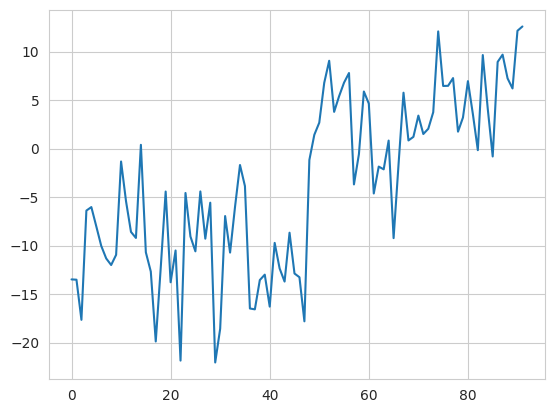

In [19]:
jd.resolve_graph()
prior_predictive = jd.sample()
prior_predictive.keys()
prior_predictive['y'].shape

plt.plot(prior_predictive['y'][0,0,:,0,0].numpy())
jd.log_prob(prior_predictive)

In [20]:
params = [p for p in prior_predictive.keys() if 'y' not in p]
print(f"params: {params}")
print(f"len(params): {len(params)}")

params: ['fourier_weights_prior', 'b_fourier', 'b0_prior', 'b0', 'b1_prior', 'b1', 'b2_prior', 'b2', 'error']
len(params): 9


In [21]:
n_chains = 4
n_samples = 200
sample = jd.sample(n_chains)
sample
del sample['y']
sample.keys()
init_state = [
    tf.zeros_like(samp)
    if ('prior' not in param) & ('error' not in param)
    else tf.ones_like(samp)
    for param, samp in sample.items()
    ]

step_size = [tf.cast(i, dtype=tf.float32) for i in np.ones(len(init_state))]
unconstraining_bijectors = [
    tfb.Identity()
    if ('prior' not in param) & ('error' not in param)
    else tfb.Exp()
    for param in sample.keys()
    ]

jd_pinned = jd.experimental_pin(
    y=y_std
)
target_log_prob_fn = jd_pinned.unnormalized_log_prob

## Train

In [22]:
# start = datetime.datetime.now(pytz.timezone("US/Mountain"))
# print(f"start: {start}")

# samples, sampler_stat = run_chain(
#     init_state=init_state,
#     step_size=step_size,
#     target_log_prob_fn=target_log_prob_fn,
#     unconstraining_bijectors=unconstraining_bijectors,
#     num_steps=n_samples,
#     burnin=n_samples,
#     )

# end = datetime.datetime.now(pytz.timezone("US/Mountain"))
# print(f"training time: {end - start}")
# print(f"len(samples): {len(samples)}")
# print(f"samples[1].shape: { samples[1].shape }")

# # save
# path = '/content/drive/MyDrive/propane/samples_pm25.pickle'
# with open(path, 'wb') as f:
#     pickle.dump(samples, f)

# Posterior

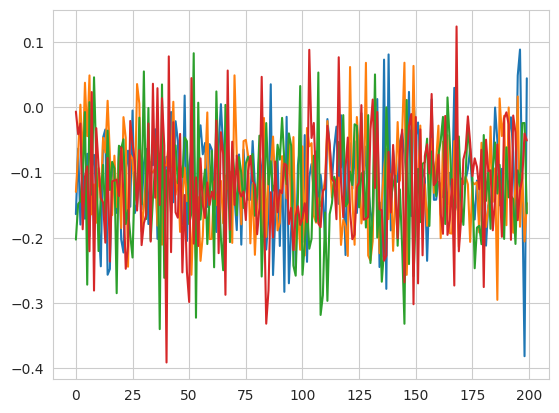

In [23]:
jd = get_joint_distribution(
        X_fourier=X_fourier,
        X_data=X_data,
        changepoints=changepoints,
        I_data=I_data,
        n_blocks_per_row=n_blocks_per_row,
        n_vars=X_data.shape[3],
)

path = '/content/drive/MyDrive/propane/samples_pm25.pickle'
with open(path, 'rb') as f:
    samples = pickle.load(f)

# n_blocks short for n_blocks_per_row
# shape = (n_samples, n_blocks, n_blocks, n_timeperiods, n_vars, n_changepoints)
for chain_idx in range(4):
    plt.plot(samples[5][:, chain_idx, 5, 5, 0, var_2_idx['propane_ahead_4'], 0])

In [24]:
# n_blocks short for n_blocks_per_row
# shape = (n_samples, n_blocks, n_blocks, n_timeperiods, n_vars, n_changepoints)
chunks=[-1, 1, 1, -1, -1, -1]
chunks=[-1, 1, 1, -1, -1, -1]

post = get_post(
    jd=jd,
    samples=samples,
    n_samples=n_samples,
    n_chains=n_chains,
    chunks=chunks,
    )
print(f"len(samples): {len(samples)}")
for param, sample in post.items():
    print(f"{param}.shape: {sample.shape}")

chunks=[-1, 1, 1, -1, -1, -1]
contribution, intercept, slope = get_piecewise_posterior(
    b0=post['b0'],
    b1=post['b1'],
    b2=post['b2'],
    I_data=I_data,
    changepoints=changepoints,
    X_data=X_data,
    chunks=chunks,
)
print(f"post.keys: {post.keys()}")
print(f"contribution.shape: {contribution.shape}")
print(f"slope.shape: {slope.shape}")
print(f"intercept.shape: {intercept.shape}")

len(samples): 9
fourier_weights_prior.shape: (800, 1, 1, 1, 1, 1)
b_fourier.shape: (800, 40, 40, 1, 1, 4)
b0_prior.shape: (800, 1, 1, 1, 2, 1)
b0.shape: (800, 40, 40, 1, 2, 1)
b1_prior.shape: (800, 1, 1, 1, 2, 1)
b1.shape: (800, 40, 40, 1, 2, 1)
b2_prior.shape: (800, 1, 1, 1, 2, 3)
b2.shape: (800, 40, 40, 1, 2, 3)
error.shape: (800, 40, 40, 1, 1, 1)
len(samples): 9
fourier_weights_prior.shape: (800, 1, 1, 1, 1, 1)
b_fourier.shape: (800, 40, 40, 1, 1, 4)
b0_prior.shape: (800, 1, 1, 1, 2, 1)
b0.shape: (800, 40, 40, 1, 2, 1)
b1_prior.shape: (800, 1, 1, 1, 2, 1)
b1.shape: (800, 40, 40, 1, 2, 1)
b2_prior.shape: (800, 1, 1, 1, 2, 3)
b2.shape: (800, 40, 40, 1, 2, 3)
error.shape: (800, 40, 40, 1, 1, 1)
post.keys: dict_keys(['fourier_weights_prior', 'b_fourier', 'b0_prior', 'b0', 'b1_prior', 'b1', 'b2_prior', 'b2', 'error'])
contribution.shape: (800, 40, 40, 92, 2, 1)
slope.shape: (800, 40, 40, 92, 2, 1)
intercept.shape: (800, 40, 40, 92, 2, 1)


In [25]:
post_mean = {
    param: sample.mean(axis=0)
    for param, sample in post.items()
    }
contribution_mean, intercept_mean, slope_mean = get_piecewise_posterior(
    b0=post_mean['b0'],
    b1=post_mean['b1'],
    b2=post_mean['b2'],
    I_data=I_data,
    changepoints=changepoints,
    X_data=X_data,
    chunks=chunks,
)

seasonal_mean = (post_mean['b_fourier'] * X_fourier.numpy()).sum(axis=4, keepdims=True).compute()

print(f"var_2_idx: {var_2_idx}")
print(f"contribution_mean.shape: {contribution_mean.shape}")
print(f"slope_mean.shape: {slope_mean.shape}")
print(f"intercept_mean.shape: {intercept_mean.shape}")
print(f"seasonal_mean.shape: {seasonal_mean.shape}")

var_2_idx: {'trend': 0, 'propane_ahead_4': 1}
contribution_mean.shape: (1, 40, 40, 92, 2, 1)
slope_mean.shape: (1, 40, 40, 92, 2, 1)
intercept_mean.shape: (1, 40, 40, 92, 2, 1)
seasonal_mean.shape: (40, 40, 92, 1, 1)


## Analysis

i: 5, j: 7


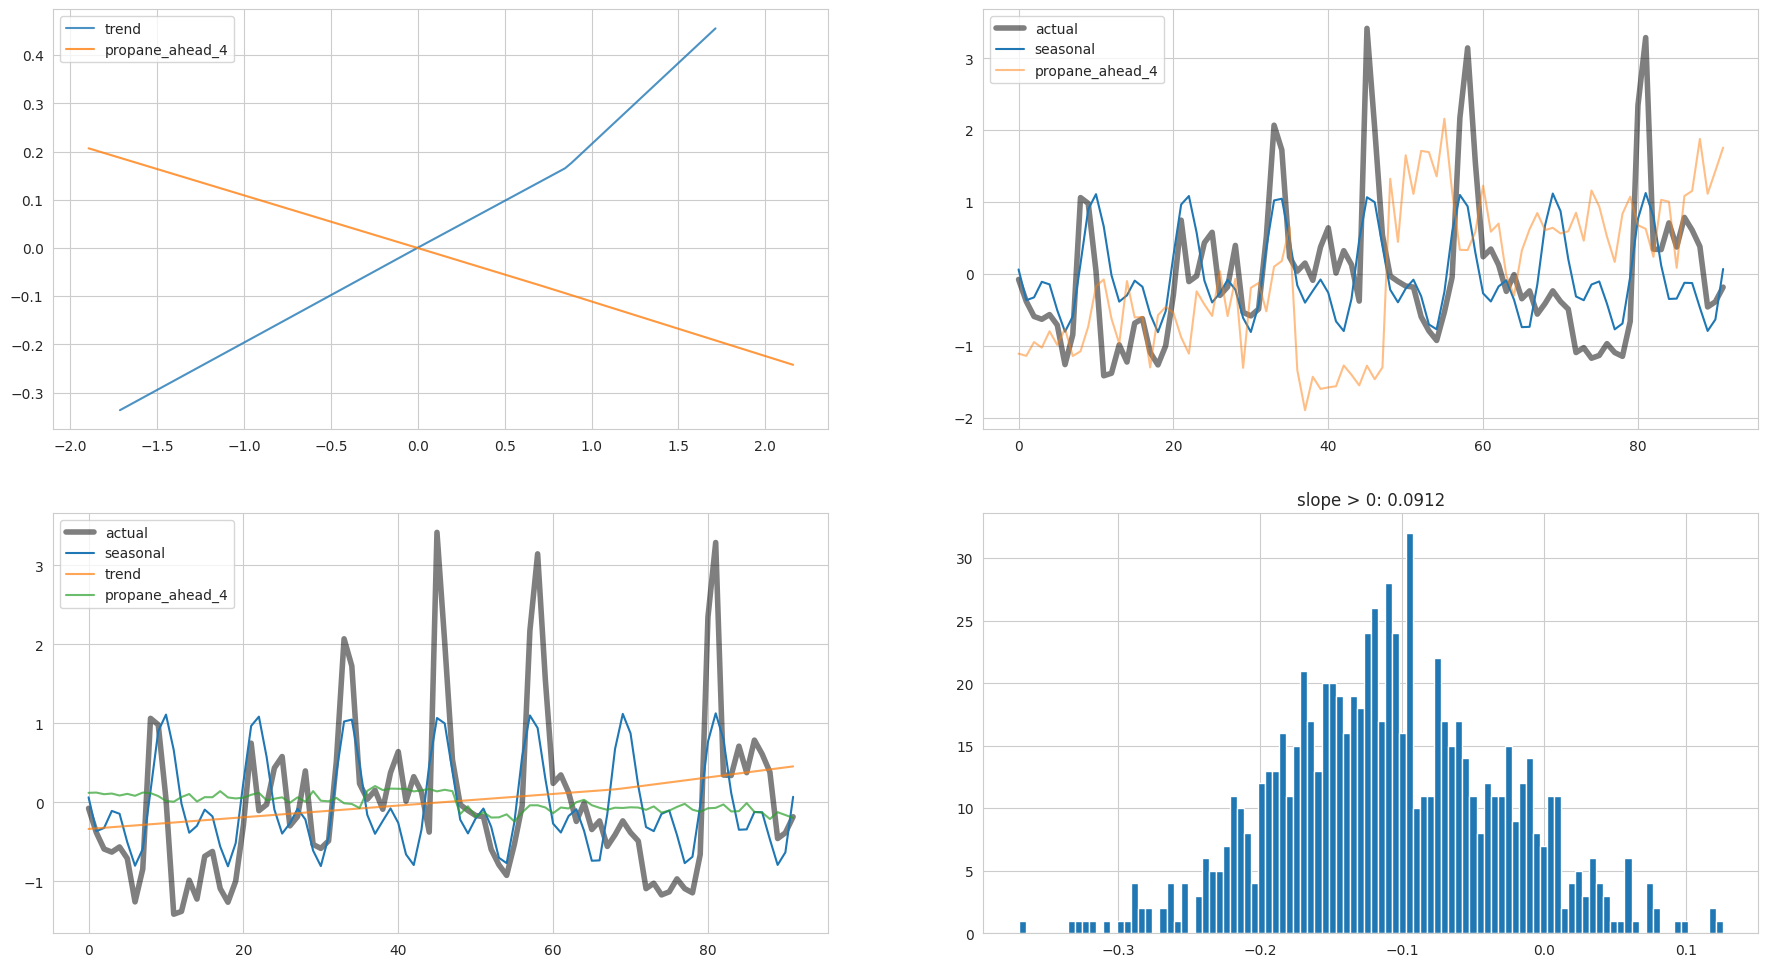

In [26]:
i,j=np.random.choice(np.arange(10), size=1)[0],np.random.choice(np.arange(10), size=1)[0]
print(f"i: {i}, j: {j}")

# X: fourier components, piecewise_vars = trend, clouds, rain, heat, propane
f, ax = plt.subplots(2, 2, figsize=[22,12])
for var_idx in range(len(vars)):
    # if idx_2_var[var_idx] != 'clouds':
        df = pd.DataFrame({
            'data':X_data[i,j,:,var_idx,0],
            'contribution':contribution_mean[0, i,j,:,var_idx,0],
            }).sort_values(['data'])
        ax[0,0].plot(df['data'], df['contribution'], ls='-', alpha=0.8, label=idx_2_var[var_idx])
ax[0,0].legend()

ax[0,1].plot(y_std[i,j,:,0,0], alpha=0.5, lw=4, color='k', label='actual')
ax[0,1].plot(seasonal_mean[i,j,:,0,0], label='seasonal')

var = 'propane_ahead_4'
ax[0,1].plot(X_data[i,j,:,var_2_idx[var],0], alpha=0.5, label=var)
# var = 'heat'
# ax[1].plot(X_data[i,j,:,var_2_idx[var],0], alpha=0.5, label=var)
ax[0,1].legend();

ax[1,0].plot(y_std[i,j,:,0,0], alpha=0.5, lw=4, color='k', label='actual')
ax[1,0].plot(seasonal_mean[i,j,:,0,0], label='seasonal')
ax[1,0].plot(contribution_mean[0, i,j,:,var_2_idx['trend'],0], alpha=0.7, label='trend')
ax[1,0].plot(contribution_mean[0, i,j,:,var_2_idx['propane_ahead_4'],0], alpha=0.7, label='propane_ahead_4')

ax[1,0].legend()

slope_estimates = slope[:, i, j, 0, var_2_idx['propane_ahead_4'], :].compute().flatten()
ax[1,1].set_title(f"slope > 0: {(slope_estimates>0).mean():.4f}")
ax[1,1].hist(slope_estimates, bins=100);

slope_mean.shape: (40, 40)
slope_mean.mean(): -0.0412


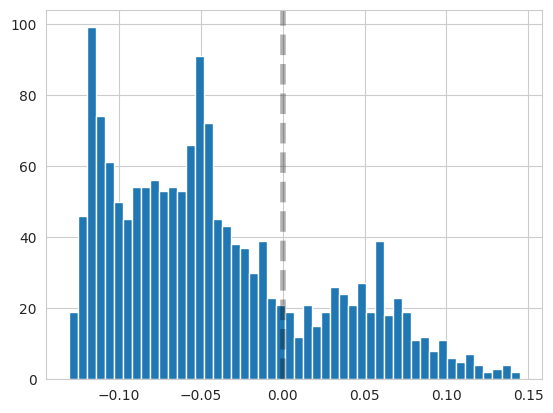

In [27]:
# n_blocks short for n_blocks_per_row
# shape = (n_samples, n_blocks, n_blocks, n_timeperiods, n_vars, n_changepoints)
slope_mean = (
    slope[:, :, :, :, var_2_idx['propane_ahead_4'], :]
    .mean(axis=0, keepdims=True) # across samples
    .mean(axis=3, keepdims=True) # across timeperiods
).compute().squeeze()
print(f"slope_mean.shape: {slope_mean.shape}")
print(f"slope_mean.mean(): {slope_mean.mean():.4f}")
plt.hist(slope_mean.flatten(), bins=50)
plt.axvline(0, ls='--', color='k', alpha=0.3, lw=4)
plt.show()

In [28]:
# n_blocks short for n_blocks_per_row
# shape = (n_samples, n_blocks, n_blocks, n_timeperiods, n_vars, n_changepoints)
slope_negative = (
    (slope[:, :, :, :, var_2_idx['propane_ahead_4'], :] < 0)
    .mean(axis=0, keepdims=True) # across samples
    .mean(axis=3, keepdims=True) # across timeperiods
).compute().squeeze()
print(f"slope_negative.shape: {slope_negative.shape}")
print(f"slope_negative.mean(): {slope_negative.mean():.4f}")

slope_negative.shape: (40, 40)
slope_negative.mean(): 0.6720


## map contour

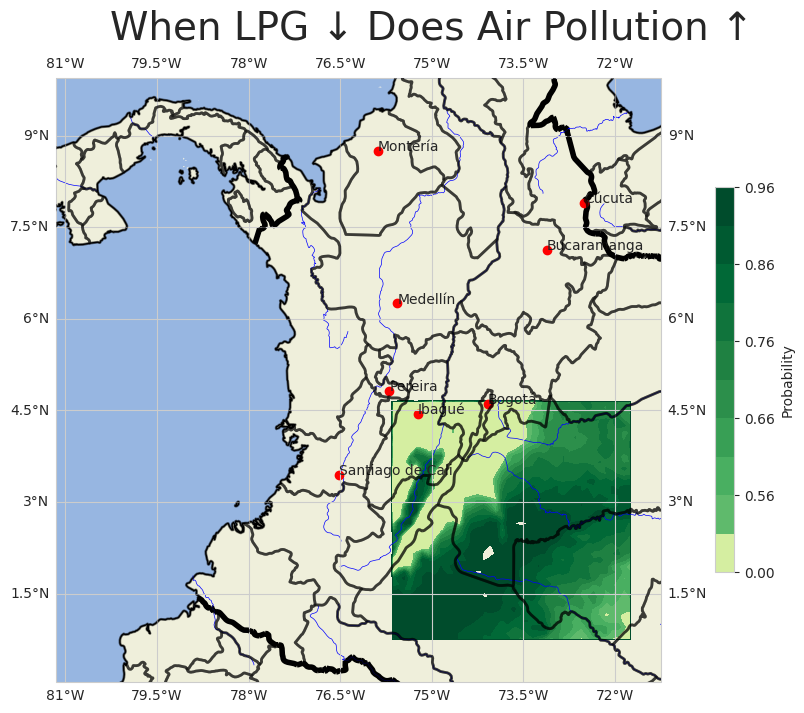

In [32]:
data = slope_negative.copy()
levels = np.concatenate([np.array([0]), np.arange(start=0.51, stop=1, step=0.01)])

plot_contour(
    y=0.68,
    cities=cities,
    data_base=y_data.squeeze()[:,:,0],
    data_learned=data.squeeze(),
    data=y_data.squeeze()[:,:,0],
    lat=lat,
    lon=lon,
    start_lat=start_lat,
    stop_lat=stop_lat,
    start_lon=start_lon,
    stop_lon=stop_lon,

    title="When LPG ↓ Does Air Pollution ↑",
    levels=np.concatenate([
        np.zeros(1),
        np.arange(
            start=0.51,
            stop=np.max(slope_negative),
            step=0.05,
            )])
    )